**Poisson equation over L-shaped domain**

Retyped by Theodoret Putra Agatho on 7 Aug. 2023

[Source](https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/poisson.Lshape.html)

In [3]:
pip install deepxde

**Problem setup**

We will solve a Poisson equation:

\begin{align}
        -u_{xx} - u_{yy} = 1, \Omega = [-1, 1]^2 \text{ \ } [0, 1]^2
    \end{align}

with the Dirichlet boundary conditions

\begin{align}
        u(x, y) = 0, (x, y) \in \delta \Omega
    \end{align}

**Impelementation**

This description goes through the implemenetation of a solver for the above described Poisson equation step-by-step.

First, the DeepXDE module is imported:

In [4]:
import deepxde as dde

We begin by defining a computational geometry. We can use a built-in class `Polygon` as follows

In [5]:
geom = dde.geometry.Polygon([[0, 0], [1, -1], [-1, -1], [-1, 1], [0, 1]])

The geometry in this case is a polygon with six line segments, which is in a L-shape.

Next, we express the PDE residual of the Poisson equation:

In [6]:
def pde(x, y):
  dy_xx = dde.grad.hessian(y, x, i=0, j=0)
  dy_yy = dde.grad.hessian(y, x, i=1, j=1)
  return -dy_xx - dy_yy - 1

The first argument to `pde` is the network input, i.e., the $x$-coordinate. The second argument is the network output, i.e., the solution $u(x)$, but here we use `y` as the name of the variable.

Next, we consider the Dirichlet boundary condition. A simple Python function, returning a boolean, is used to define the subdomain for the Dirichlet boundary condition. The function should return `True` for those points inside the subdomain and `False` for the points outside. In our case, the point $(x, y)$ of the Dirichlet boundary condition are $(x, y) \in \partial {[-1, 1]^2 \text{ \ } [0, 1]^2}$.

In [7]:
def boundary(_, on_boundary):
  return on_boundary

Then, the Dirichlet boundary condition is

In [8]:
bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary)

Now, we have specified the geometry, PDE residual, and Dirichlet boundary condition. We then define the PDE problem as

In [9]:
data = dde.data.PDE(geom, pde, bc, num_domain=1200, num_boundary=120, num_test=1500)

The number 1200 is the number of training residual points sampled inside the domain, and the number 120 is the number of training sampled on the boundary. We use 1500 residual points for testing the PDE residual.

Next, we choose the network. Here, we use a fully connected neural network of depth 5 (i.e., 4 hidden layers) and width 50. Besides, we choose `tanh` as activation function and `Glorot uniform` as initializer:

In [10]:
net = dde.nn.FNN([2] + [50] * 4 + [1], "tanh", "Glorot uniform")

Now, we have the PDE problem and the network. We build a `Model` and choose the optimizer and learning rate:

In [11]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001)

Compiling model...
Building feed-forward neural network...
'build' took 0.125580 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.269028 s



We first train the model for 50000 iterations with Adam optimizer:

In [12]:
model.train(iterations=50000)

Training model...

Step      Train loss              Test loss               Test metric
0         [1.10e+00, 5.61e-02]    [1.10e+00, 5.61e-02]    []  
1000      [3.44e-04, 1.20e-03]    [2.89e-04, 1.20e-03]    []  
2000      [2.79e-04, 1.40e-03]    [2.17e-04, 1.40e-03]    []  
3000      [1.66e-04, 8.25e-04]    [1.32e-04, 8.25e-04]    []  
4000      [1.38e-04, 7.39e-04]    [1.11e-04, 7.39e-04]    []  
5000      [7.98e-05, 6.15e-04]    [6.14e-05, 6.15e-04]    []  
6000      [6.48e-05, 3.93e-04]    [4.74e-05, 3.93e-04]    []  
7000      [4.81e-05, 2.55e-04]    [3.68e-05, 2.55e-04]    []  
8000      [1.83e-04, 2.09e-04]    [1.63e-04, 2.09e-04]    []  
9000      [3.69e-05, 1.01e-04]    [2.88e-05, 1.01e-04]    []  
10000     [4.83e-05, 6.99e-05]    [3.68e-05, 6.99e-05]    []  
11000     [2.44e-05, 5.37e-05]    [1.86e-05, 5.37e-05]    []  
12000     [2.14e-05, 5.09e-05]    [1.78e-05, 5.09e-05]    []  
13000     [4.84e-05, 5.39e-05]    [5.01e-05, 5.39e-05]    []  
14000     [1.26e-05, 4.18e-05

(<deepxde.model.LossHistory at 0x78858d30afe0>,
 <deepxde.model.TrainState at 0x78858d3082b0>)

And then we train the model again using L-BFGS

In [13]:
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.488369 s

Training model...

Step      Train loss              Test loss               Test metric
50000     [6.17e-06, 1.88e-05]    [5.49e-06, 1.88e-05]    []  
51000     [1.87e-06, 7.01e-06]    [1.87e-06, 7.01e-06]        
52000     [1.53e-06, 4.54e-06]    [1.53e-06, 4.54e-06]        
53000     [1.03e-06, 2.83e-06]    [1.03e-06, 2.83e-06]        
53181     [1.04e-06, 2.54e-06]    [1.35e-06, 2.54e-06]    []  

Best model at step 53181:
  train loss: 3.58e-06
  test loss: 3.89e-06
  test metric: []

'train' took 312.744880 s



Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


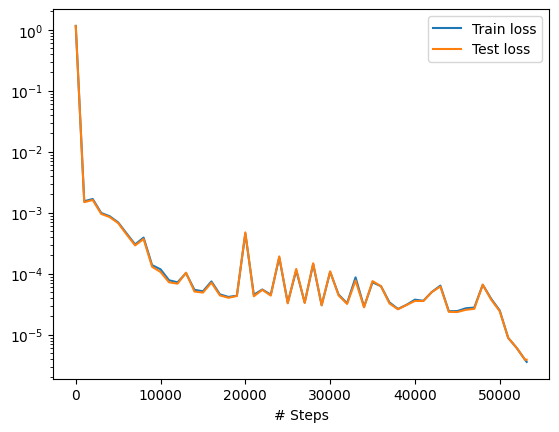

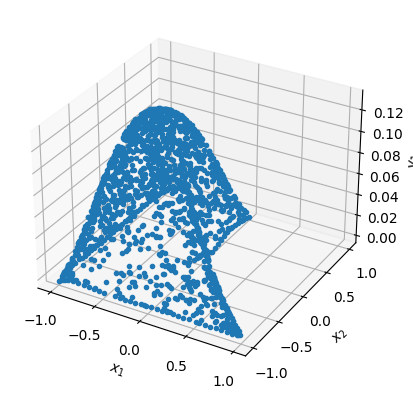

In [14]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)